# CS 117 Project

**Name:** Noah Driker    
**SID:**  ndriker (94574697)

In [1]:
import os
import cv2
import numpy as np
import pickle
from scipy.spatial import Delaunay
import trimesh

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

from camutils import makerotation, Camera, triangulate, residuals, calibratePose
import visutils

from selectpoints import select_k_points

%matplotlib notebook

final_version = 1

In [2]:
plt.rcParams['figure.figsize']=[15,15] #adjust this as needed to get clearly visible figures

# Steps

1. Calibrate
2. Decode
3. Reconstruct
4. Smooth
5. Triangulate
6. Stitch Meshes
7. Poisson Surface Reconstruction



# 1. Calibration
Check that calibration.pickle exists. If not, run calibrate to get the camera intrinsic parameters

In [17]:
if __name__ == "__main__":
    if ( not os.path.isfile('./calibration.pickle') ):
        # can call the script by importing
        import calibrate

<IPython.core.display.Javascript object>


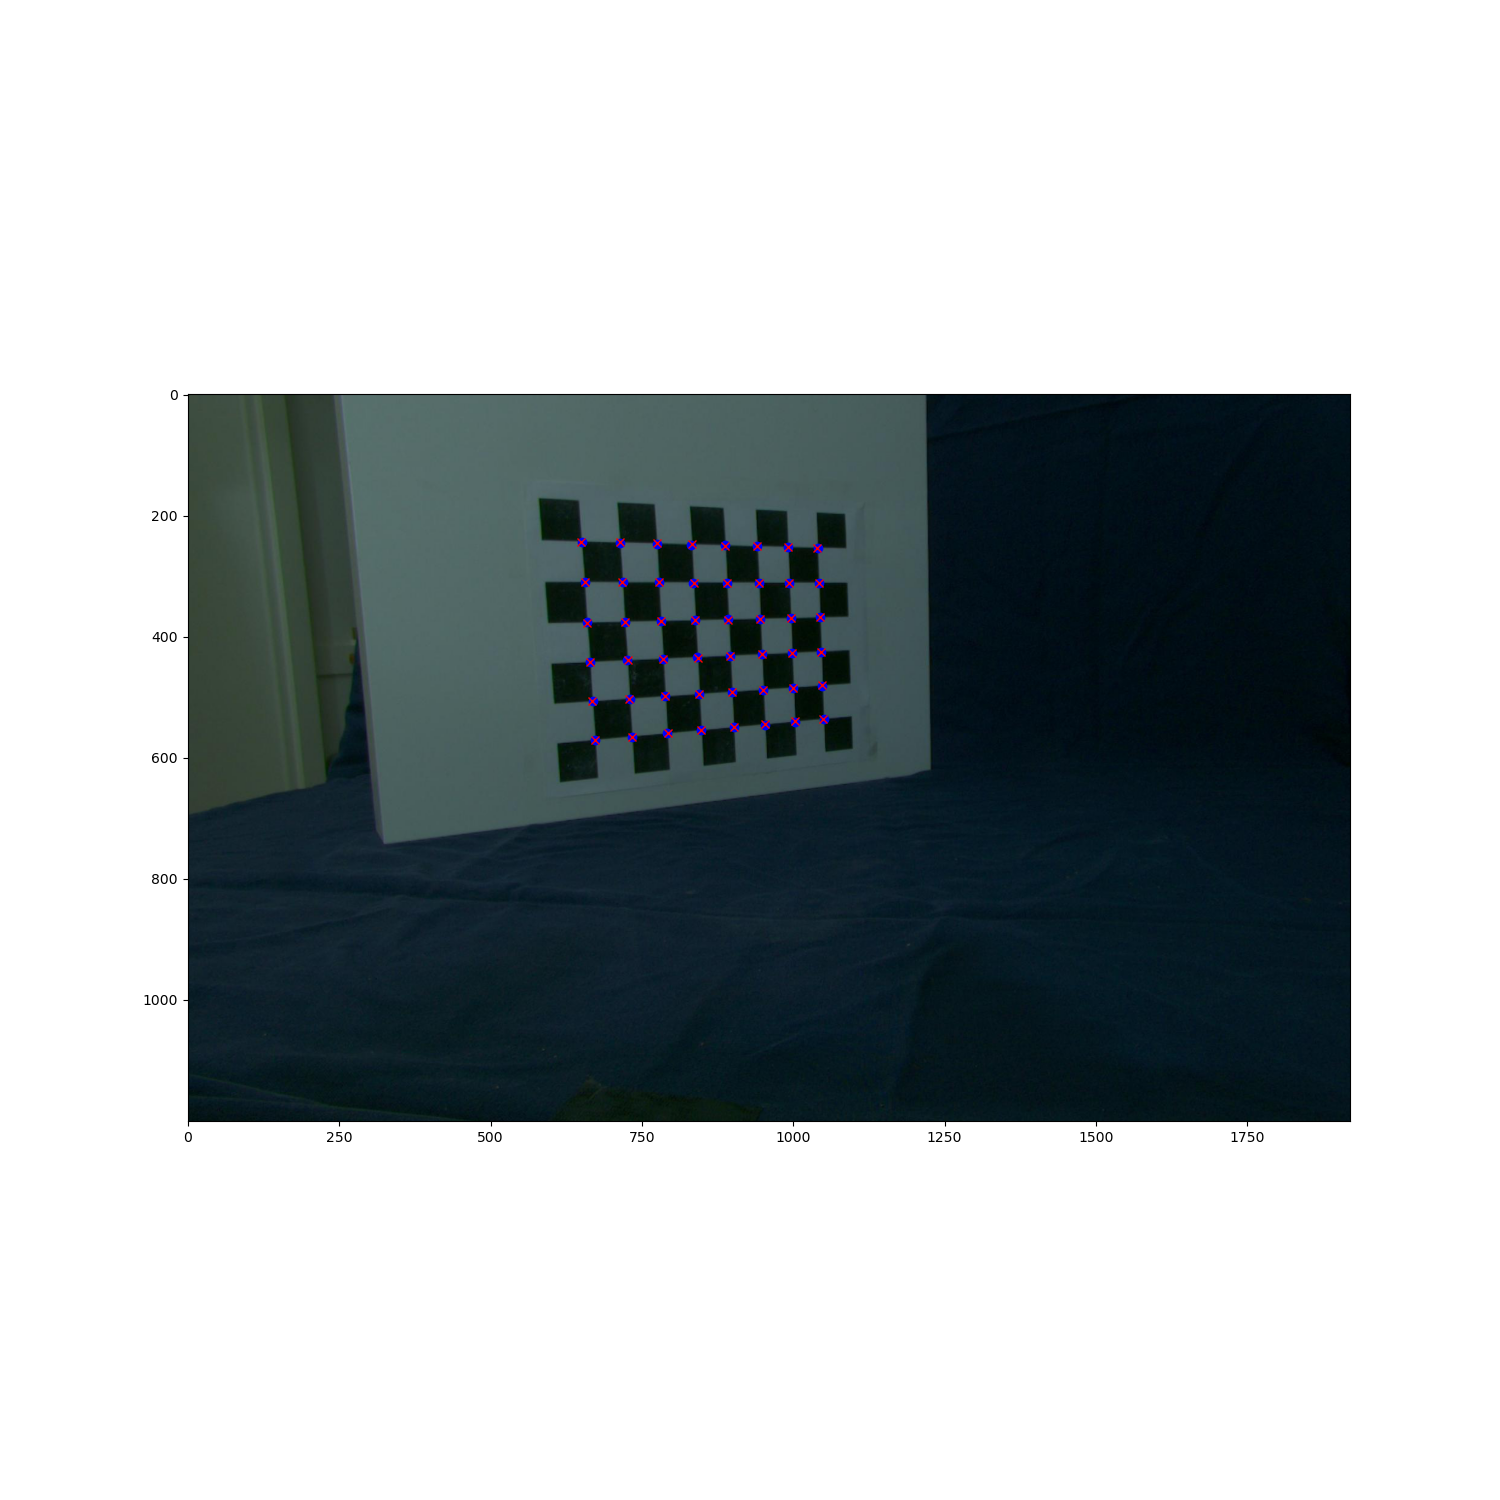

<IPython.core.display.Javascript object>


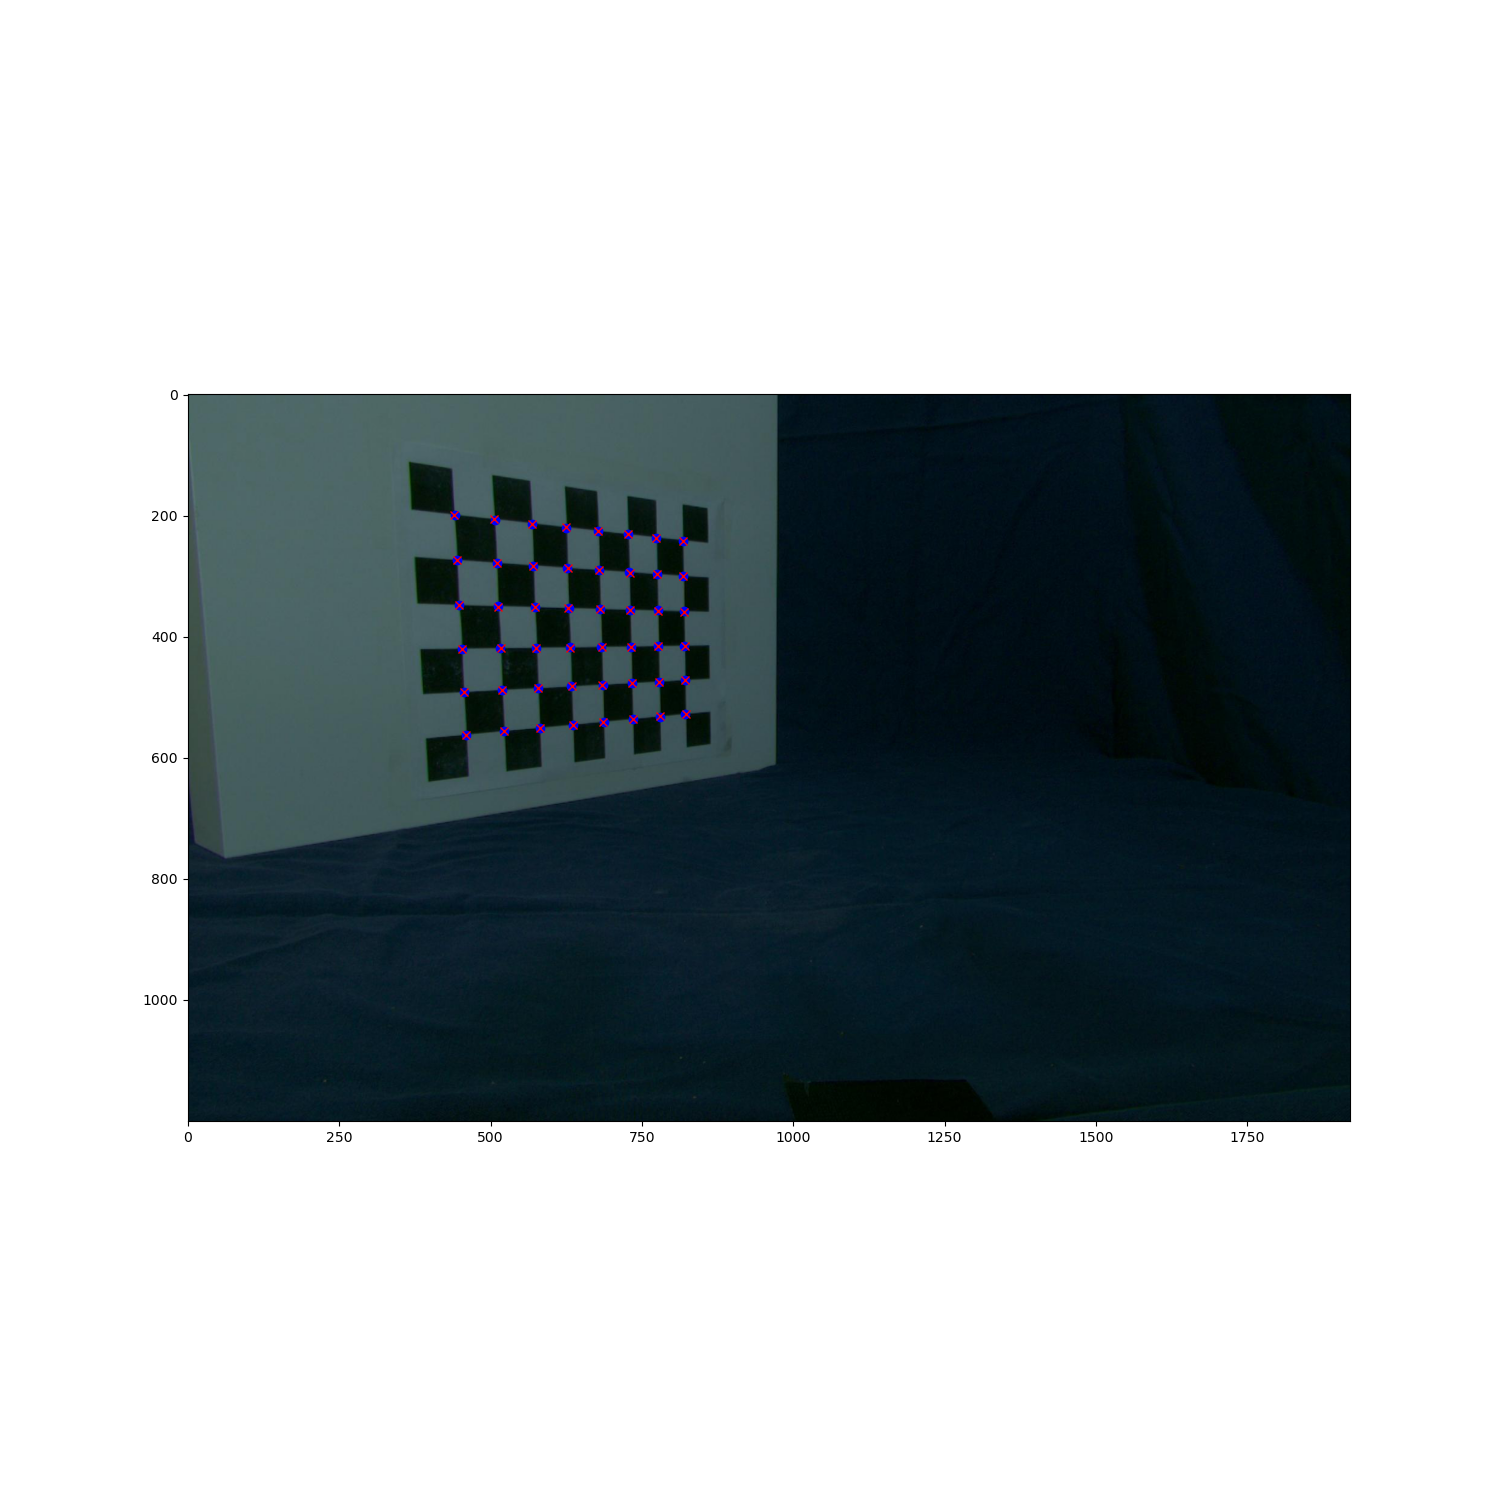

Camera : 
 f=1404.6009661788062 
 c=[[962.16736916 590.91595682]] 
 R=[[ 0.04237413  0.99207514  0.11828508]
 [ 0.87061203 -0.09474566  0.48276075]
 [ 0.49014194  0.08252385 -0.86772732]] 
 t = [[  8.15884704 -18.70825718  59.51710069]]
Camera : 
 f=1404.6009661788062 
 c=[[962.16736916 590.91595682]] 
 R=[[ 0.00217571  0.99082383  0.13514213]
 [ 0.65889089 -0.10307958  0.74514253]
 [ 0.75223538  0.0874227  -0.65306907]] 
 t = [[  7.63972935 -28.46393404  51.44184307]]


In [18]:
fid = open('./calibration.pickle','rb')
intr_params = pickle.load(fid)

fx = intr_params['fx']
fy = intr_params['fy']
cx = intr_params['cx']
cy = intr_params['cy']
fid.close()

# just average fx, fy to get focal length
focal_len = (fx + fy)/2

# configure cameras with intrinsic parameters
camL = Camera(f=focal_len,c=np.array([[cx,cy]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
camR = Camera(f=focal_len,c=np.array([[cx,cy]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))

# load in the left and right images and find the coordinates
#     of the chessboard corners using OpenCV
imgL = plt.imread('calib_jpg_u/frame_C0_21.jpg')
_, cornersL = cv2.findChessboardCorners(imgL, (8, 6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib_jpg_u/frame_C1_21.jpg')
_, cornersR = cv2.findChessboardCorners(imgR, (8, 6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
# the squares are 2.8cm x 2.8cm 
pts3 = np.zeros((3,6*8))
xx,yy = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*yy.reshape(1,-1)
pts3[1,:] = 2.8*xx.reshape(1,-1)

# Now use calibratePose function to get the extrinsic parameters
#     for the two images
paramsL_init = np.array([180,0,0,0,0,10])
paramsR_init = np.array([180,0,0,0,0,10])

camL = calibratePose(pts3,pts2L,camL,paramsL_init)
camR = calibratePose(pts3,pts2R,camR,paramsR_init)

# Finally, triangulate the checkerboard points based on the estimated camera pose
pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images
plt.rcParams['figure.figsize']=[15,15]

if (final_version):

    plt.figure()
    pts2Lp = camL.project(pts3)
    plt.imshow(imgL)
    plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
    plt.plot(pts2L[0,:],pts2L[1,:],'rx')
    plt.show()

    plt.figure()
    pts2Rp = camR.project(pts3)
    plt.imshow(imgR)
    plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
    plt.plot(pts2R[0,:],pts2R[1,:],'rx')
    plt.show()

print(camL)
print(camR)

In [19]:
model_view_index = 2

***

# 2. Decoding

Reads in a set of images captured with the camera showing the projected gray code and returns an array which is the same size as the camera image where each element contains the decoded value as well as a binary image mask indicating which pixels could be reliably decoded.

In [20]:
def decode(imprefix,start,threshold):

    # we will assume a 10 bit code
    nbits = 10

    # don't forget to convert images to grayscale / float after loading them in
    images = []
    
    for i in range(start, start + 20):
        num_str = format(i, "02d")
        image_name = imprefix + num_str + '.png'
        image = plt.imread(image_name)

        #convert to float data type and scale to [0..1] if necessary
        if (image.dtype == np.uint8):
            image = image.astype(float) / 256

        # convert to grayscale if necessary
        if (len(image.shape) == 3):
            image = np.mean(image, axis=2)
        images.append(image)
        
    mask = np.ones(images[0].shape)
    
    im_bits = []    
    for im_ind in range(0, len(images), 2):
        image1 = images[im_ind]
        image2 = images[im_ind + 1]
        im_bits.append( 1*(image1 > image2) )
        mask *= 1*( abs(image1 - image2) > threshold)

   
    # convert from gray code
    #     msb bit stays the same
    binary = [im_bits[0]]
    for i in range(nbits - 1):
        xor = np.logical_xor(binary[i], im_bits[i+1])
        binary.append(xor)
        
    # convert binary to decimal
    code = np.zeros(images[0].shape)
    for b_ind in range(nbits):
        code += binary[9-b_ind]*(2**b_ind)
    return code, mask

<IPython.core.display.Javascript object>


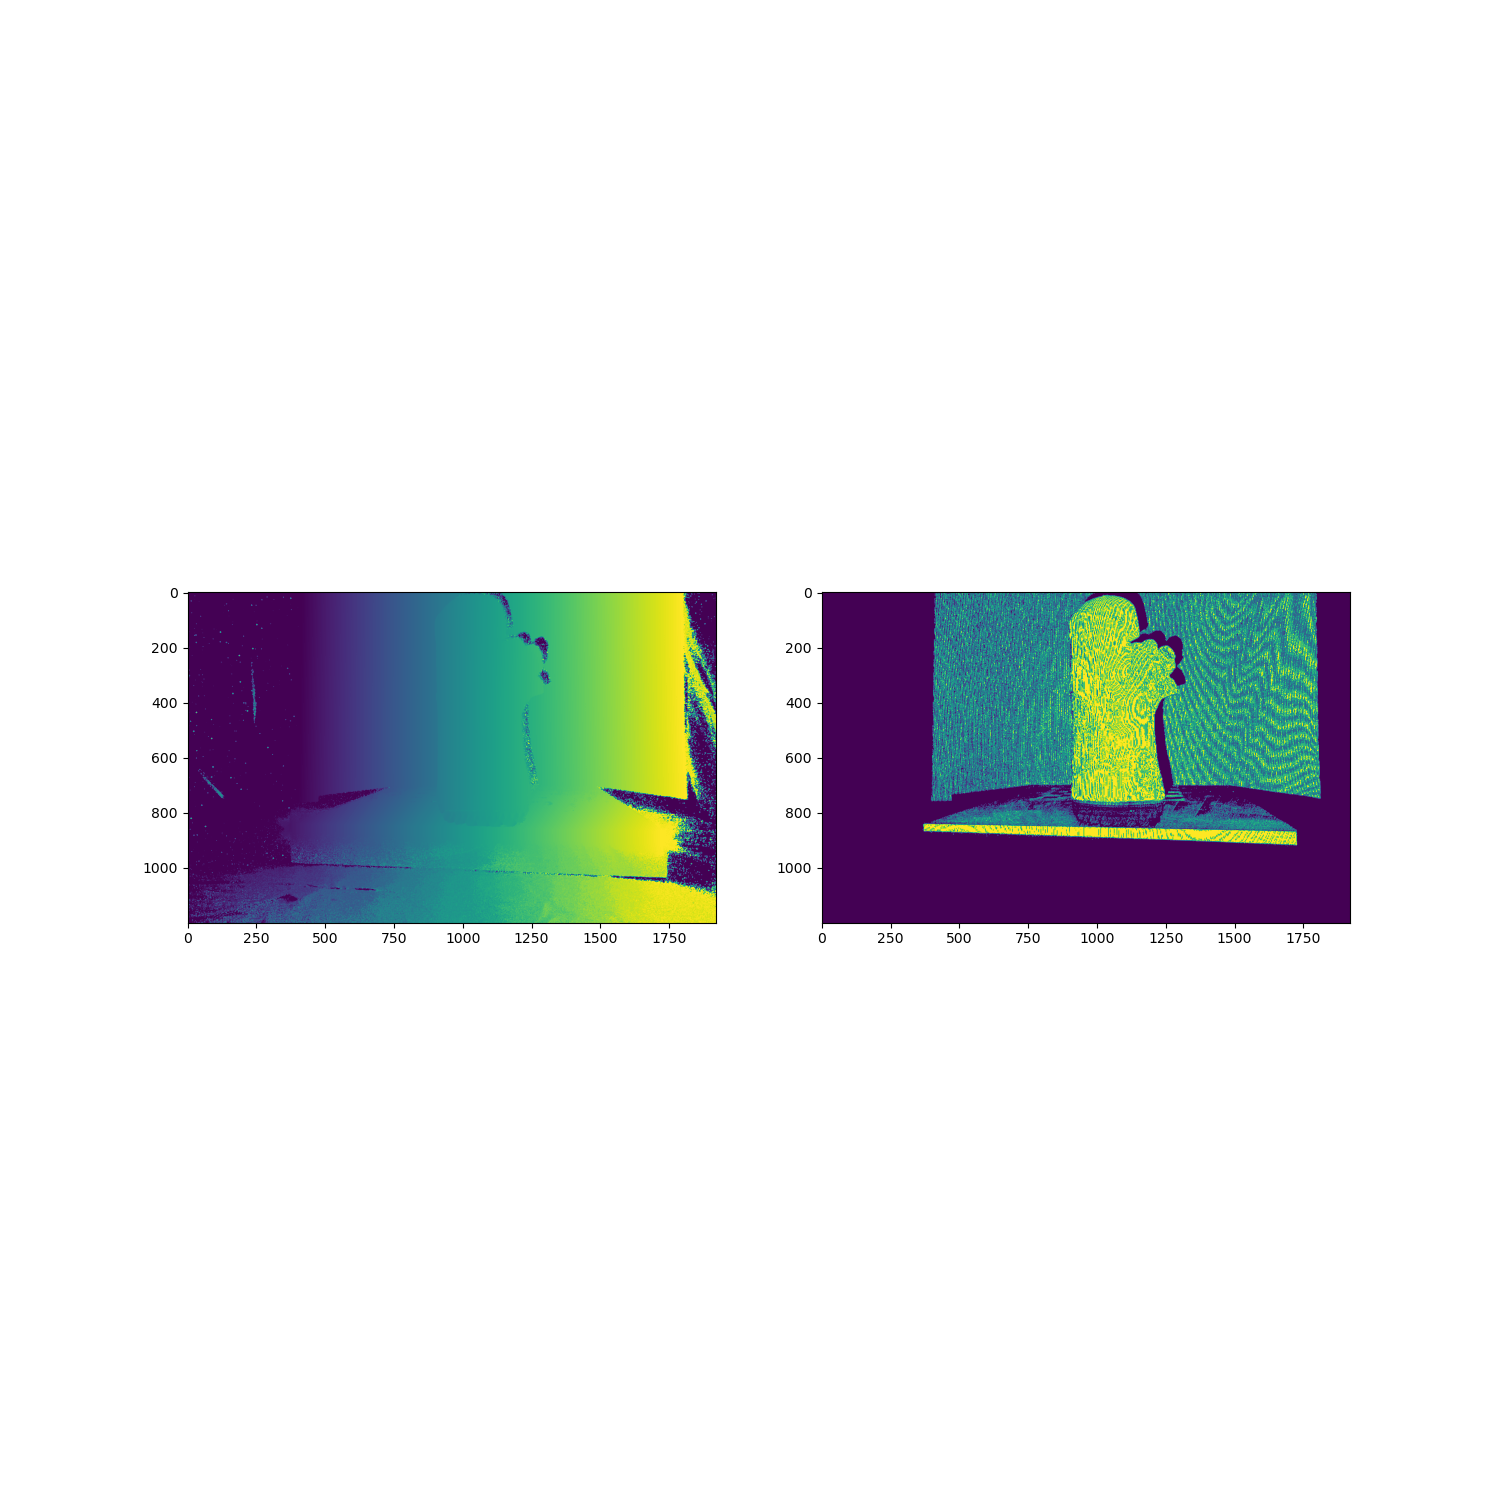

In [21]:
#
# Visualize results for the first scan and experiment to determine a good threshold
#
thresh = 0.02
code,mask = decode('C:/Users/ndriker/Documents/School/Homework/fall23/cs117/project/couple/grab_0_u/frame_C0_',0,thresh)

if (final_version):
    # display view code and mask as images
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.imshow(code)
    ax = fig.add_subplot(1,2,2)
    ax.imshow(mask)


In [22]:
def reconstruct(imprefixL,imprefixR,threshold,camL,camR):

    # Decode the H and V coordinates for the two views
    HLcode, HLmask = decode(imprefixL,  0, threshold)
    VLcode, VLmask = decode(imprefixL, 20, threshold)
    
    HRcode, HRmask = decode(imprefixR,  0, threshold)
    VRcode, VRmask = decode(imprefixR, 20, threshold)

    # Construct the combined 20 bit code C = H + 1024*V and mask for each view
    Lmask = HLmask * VLmask
    Rmask = HRmask * VRmask
    
    CL = Lmask * (HLcode + 1024*VLcode)
    CR = Rmask * (HRcode + 1024*VRcode)
    
    matchL = np.intersect1d(CL, CR, return_indices=1)[1]
    matchR = np.intersect1d(CR, CL, return_indices=1)[1]

    h, w = HLcode.shape
    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))
    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    # Now triangulate the points
    pts3 = triangulate(pts2L, camL, pts2R, camR)
    
    imageL = plt.imread(f'C:/Users/ndriker/Documents/School/Homework/fall23/cs117/project/couple/grab_{model_view_index}_u/color_C0_01.png')
    imageR = plt.imread(f'C:/Users/ndriker/Documents/School/Homework/fall23/cs117/project/couple/grab_{model_view_index}_u/color_C1_01.png')

    colorsL = np.array([imageL[pts2L[1][i]][pts2L[0][i]] for i in range(pts2L.shape[1])]).T
    colorsR = np.array([imageR[pts2R[1][i]][pts2R[0][i]] for i in range(pts2L.shape[1])]).T
    colors = (colorsL + colorsR) / 2

    return pts2L, pts2R, pts3, colors

<IPython.core.display.Javascript object>


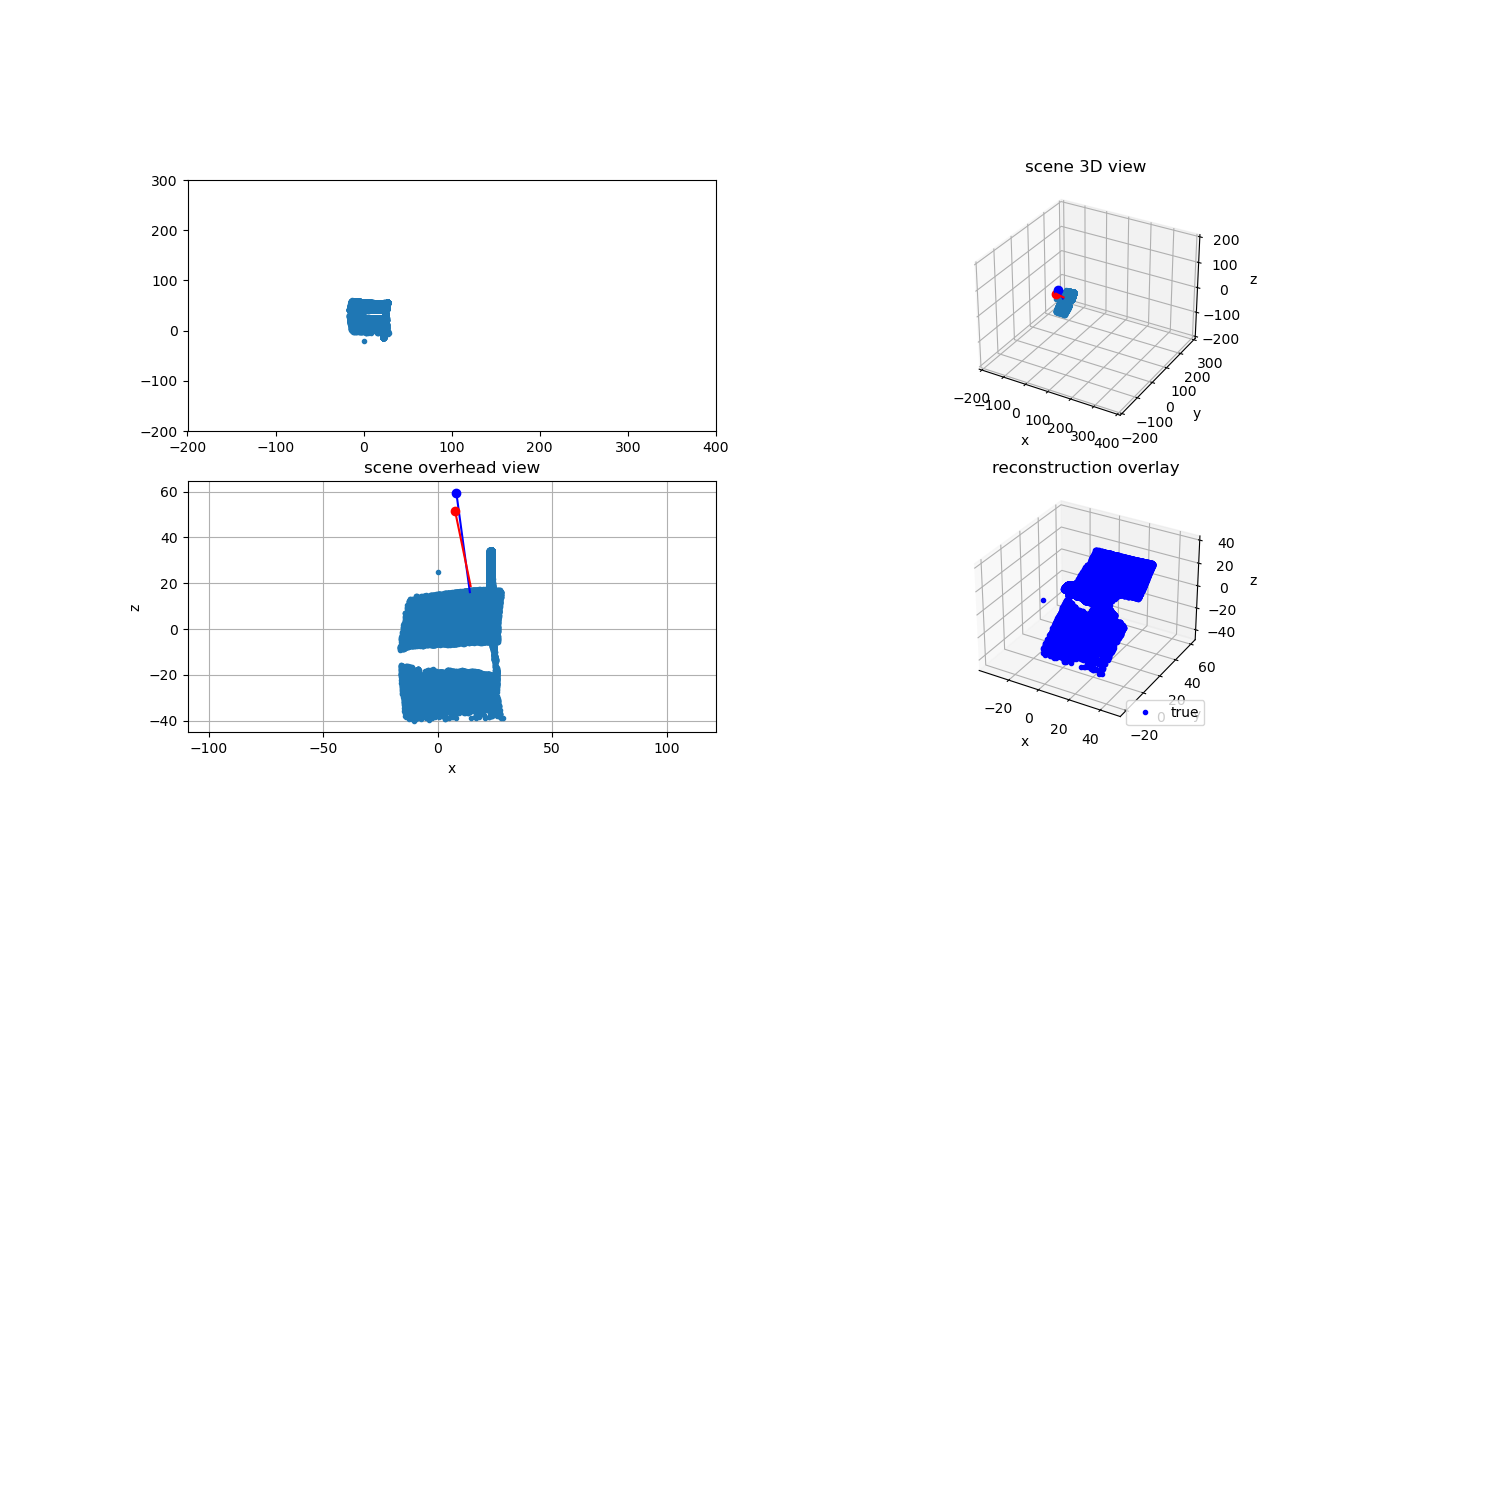

In [23]:

base_dir = 'C:/Users/ndriker/Documents/School/Homework/fall23/cs117/project/couple/'
threshold = 0.02

grab_name = "grab_" + str(model_view_index) + "_u"
imprefixC0 = base_dir + grab_name + "/frame_C0_"
imprefixC1 = base_dir + grab_name + "/frame_C1_"
pts2L, pts2R, pts3, colors = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)    

    
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,50]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,50]]).T))

tL = camL.t
tR = camR.t

if (final_version):
    fig = plt.figure()

    ax = fig.add_subplot(4,2,1)
    ax.plot(pts3[0,:],pts3[1,:],'.')
    plt.axis([-200, 400, -200, 300])

    #visualize 3D layout of points, camera positions
    # and the direction the camera is pointing
    ax = fig.add_subplot(4,2,2,projection='3d')
    ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
    ax.plot(tR[0],tR[1],tR[2],'ro')
    ax.plot(tL[0],tL[1],tL[2],'bo')
    ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
    ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
    ax.set_xlim3d([-200, 400])
    ax.set_ylim3d([-200, 300])
    ax.set_zlim3d([-200, 200])
    visutils.label_axes(ax)
    plt.title('scene 3D view')

    # overhead view showing points, camera
    # positions, and direction camera is pointed
    ax = fig.add_subplot(4,2,3)
    ax.plot(pts3[0,:],pts3[2,:],'.')
    ax.plot(tL[0],tL[2],'bo')
    ax.plot(lookL[0,:],lookL[2,:],'b')
    ax.plot(tR[0],tR[2],'ro')
    ax.plot(lookR[0,:],lookR[2,:],'r')
    plt.axis('equal')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('scene overhead view')

    # compare reconstruction
    ax = fig.add_subplot(4,2,4,projection='3d')
    ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'b.')
    visutils.set_axes_equal_3d(ax)
    visutils.label_axes(ax)
    plt.title('reconstruction overlay')
    plt.legend(('true','reconstruction'),loc=4)
    plt.show()

<IPython.core.display.Javascript object>


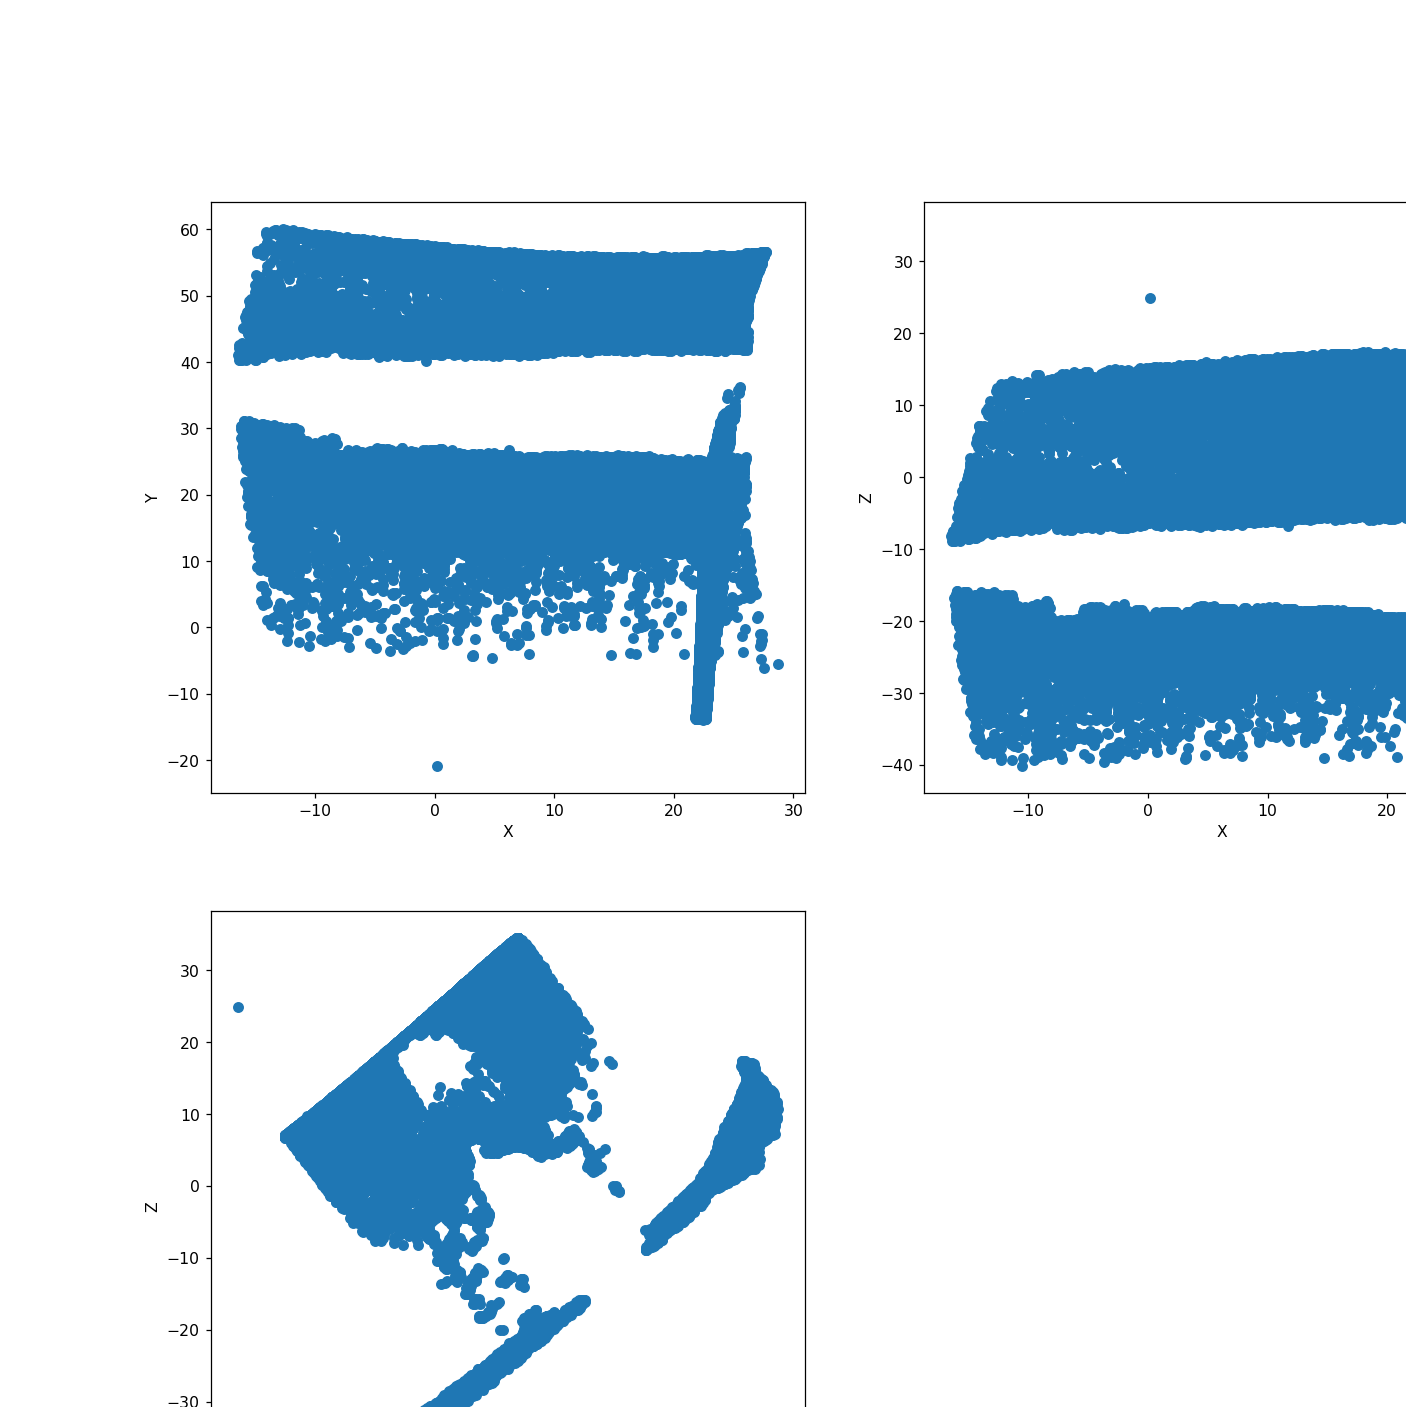

<IPython.core.display.Javascript object>


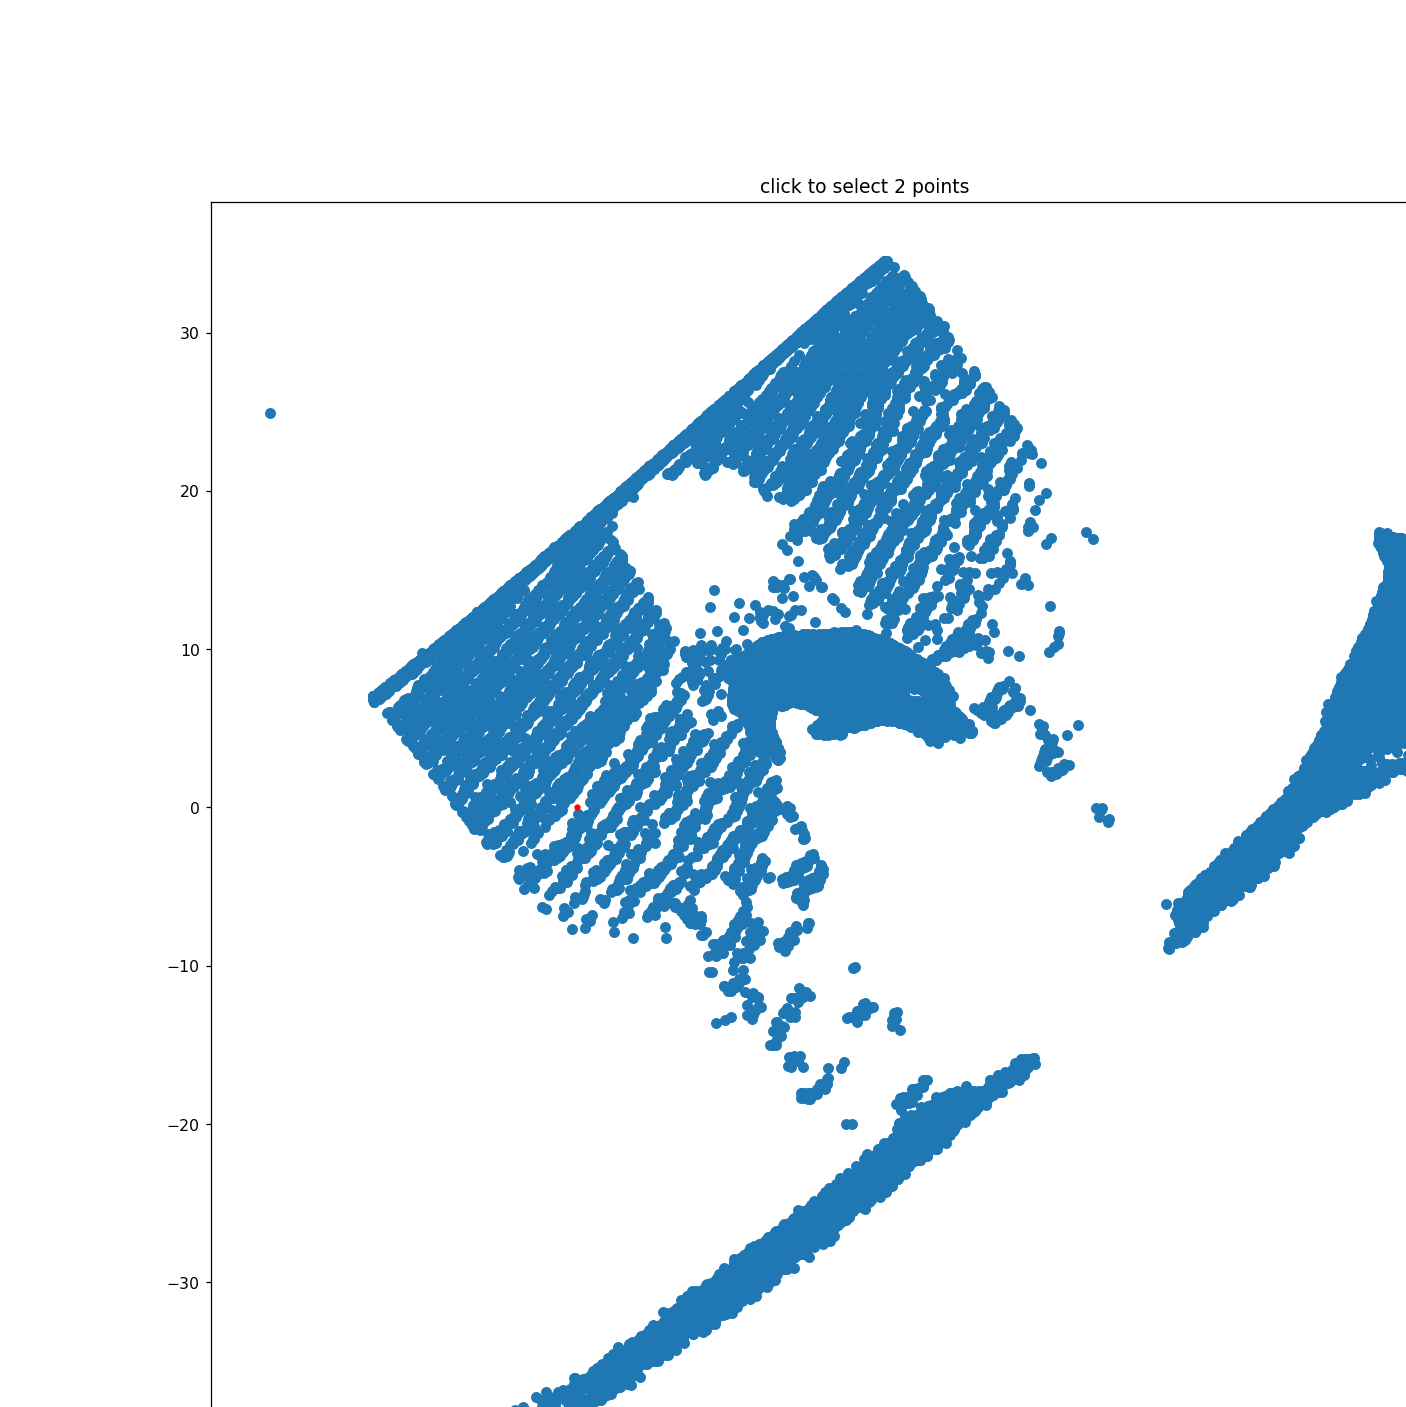

offset= 4.450960749615581


In [10]:
def plot_planes ( pts3):
    
    fig = plt.figure()
    
    # Plot x-y
    ax = fig.add_subplot(2,2,1)
    ax.scatter ( pts3[0,:], pts3[1,:] )   
    ax.set_xlabel ("X")
    ax.set_ylabel ("Y")
    
    # Plot x-z
    ax = fig.add_subplot(2,2,2)
    ax.scatter ( pts3[0,:], pts3[2,:] ) 
    ax.set_xlabel ("X")
    ax.set_ylabel ("Z")
    
    
    # Plot y-z
    ax = fig.add_subplot(2,2,3)
    ax.scatter ( pts3[1,:], pts3[2,:] ) 
    ax.set_xlabel ("Y")
    ax.set_ylabel ("Z")
    


def selectp (pts3):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter( pts3[1,:], pts3[2,:] )
    spoints = select_k_points ( ax, 2)
    return spoints

if (final_version):
    plot_planes ( pts3)
    spoints = selectp ( pts3 )


[]
[]


<IPython.core.display.Javascript object>


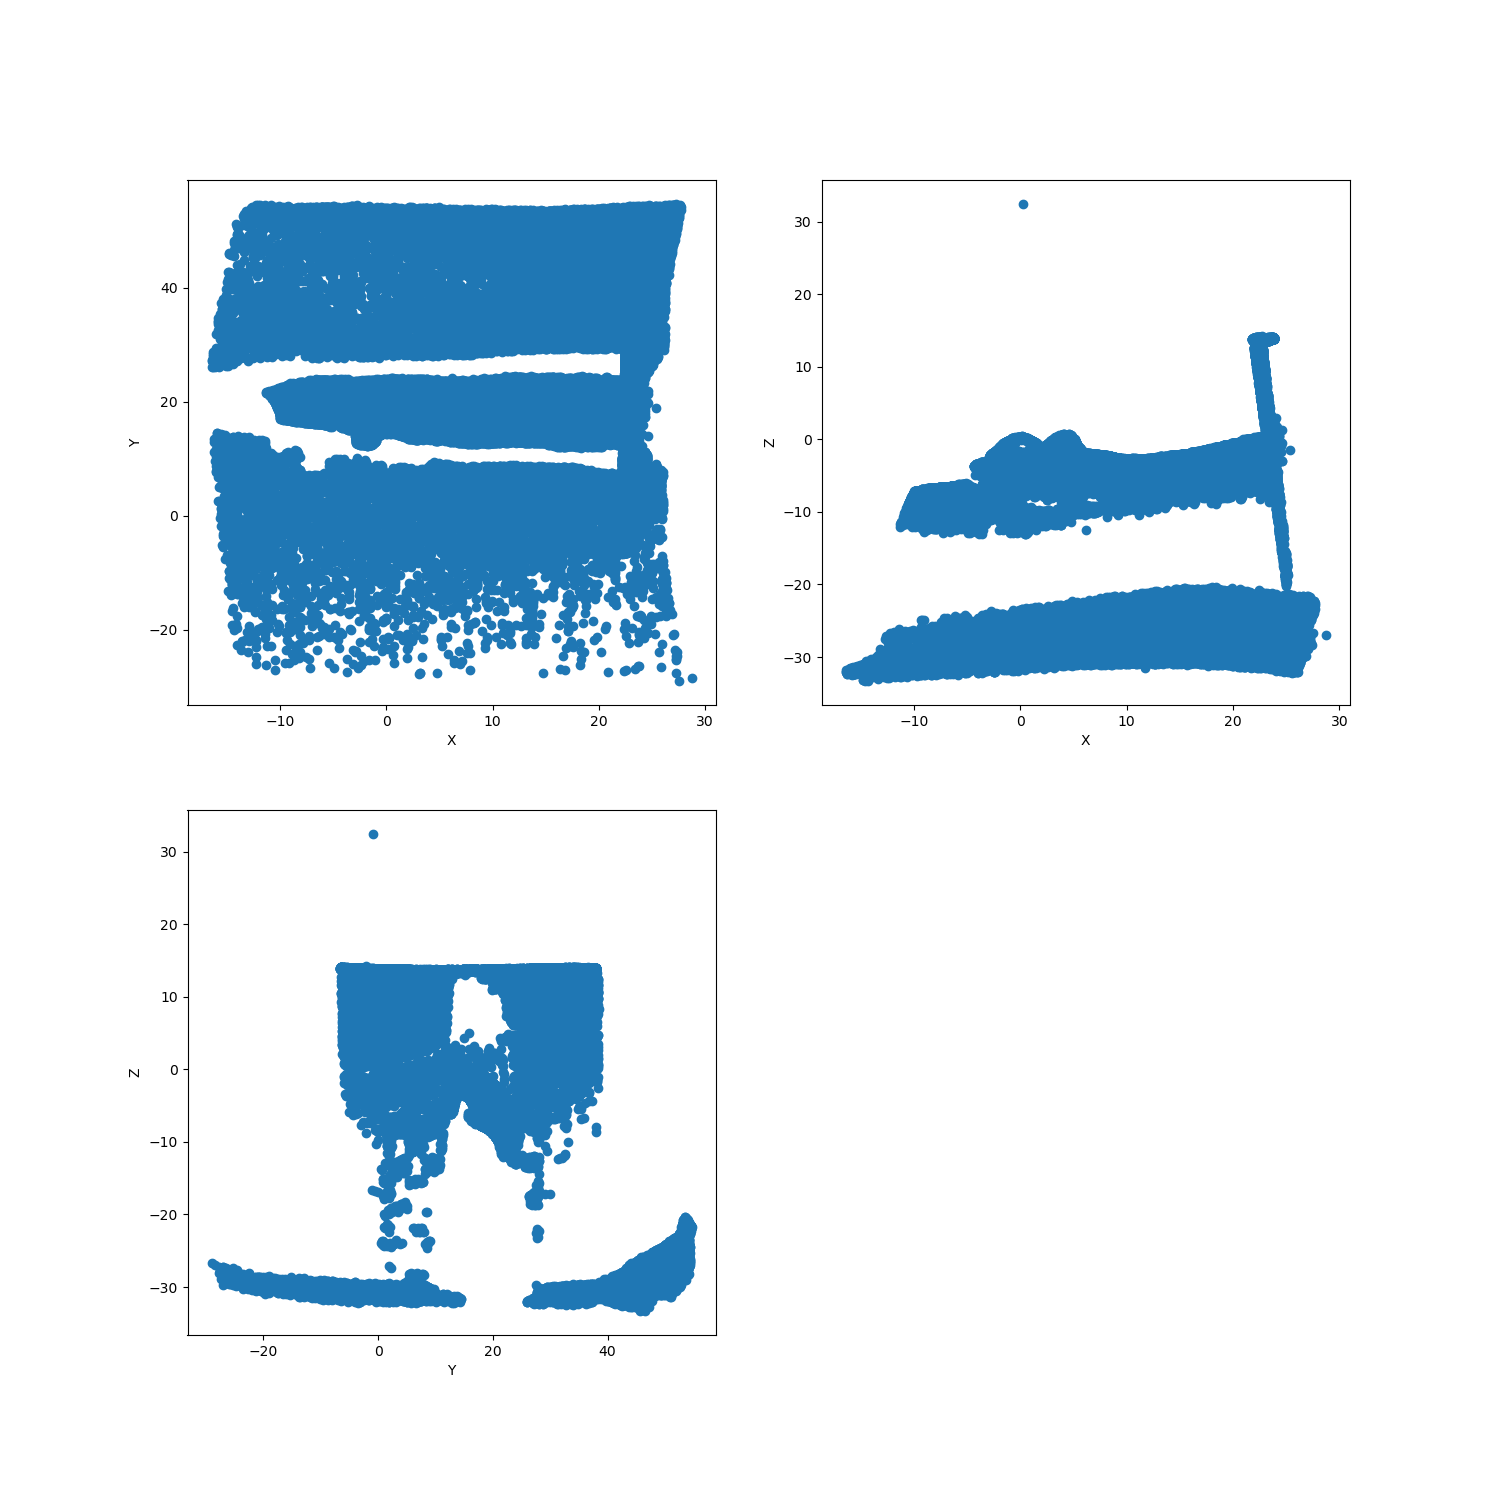

In [24]:
# rotate points so that a tighter bounding box can be fit

if (final_version):
    print ( spoints.xs)
    print ( spoints.ys)

spointxs = [
    [-9.690041617704033, 18.294318225501407],
    [-9.848437501677008, 15.60007981053652],
    [-11.886975157454895, 13.232112913312122],
    [-9.879773819460613, 16.51783922558493],
    
    [-9.231281620274434, 16.994498232784217],
    [-8.236021163819633, 17.915952658010035],
    [-9.468608461740253, 14.217458259147463]
    
    
]

spointys = [
    [10.726686896616123, 33.082939977725495],
    [10.551802802731643, 30.911238994942252],
    [8.841407891107526, 28.778711951608447],
    [10.598567698701963, 31.518393787938088],
    
    [11.118101143841912, 32.26425238100073],
    [11.59659261786748, 32.89616107562082],
    [10.788978056449935, 29.820253201240448]
    
]
spoint_x = spointxs[model_view_index]
spoint_y = spointys[model_view_index]

diff = (spoint_x[1] - spoint_x[0], spoint_y[1]-spoint_y[0])

dp = np.dot ( diff, (1,0) )

mag = np.linalg.norm(diff)


angle = np.arccos (dp / (mag))
theta = angle * 180 / np.pi

rot = makerotation ( -theta,0, 0)

rot_pts3 = rot @ pts3
if (final_version):
    plot_planes ( rot_pts3)

<IPython.core.display.Javascript object>


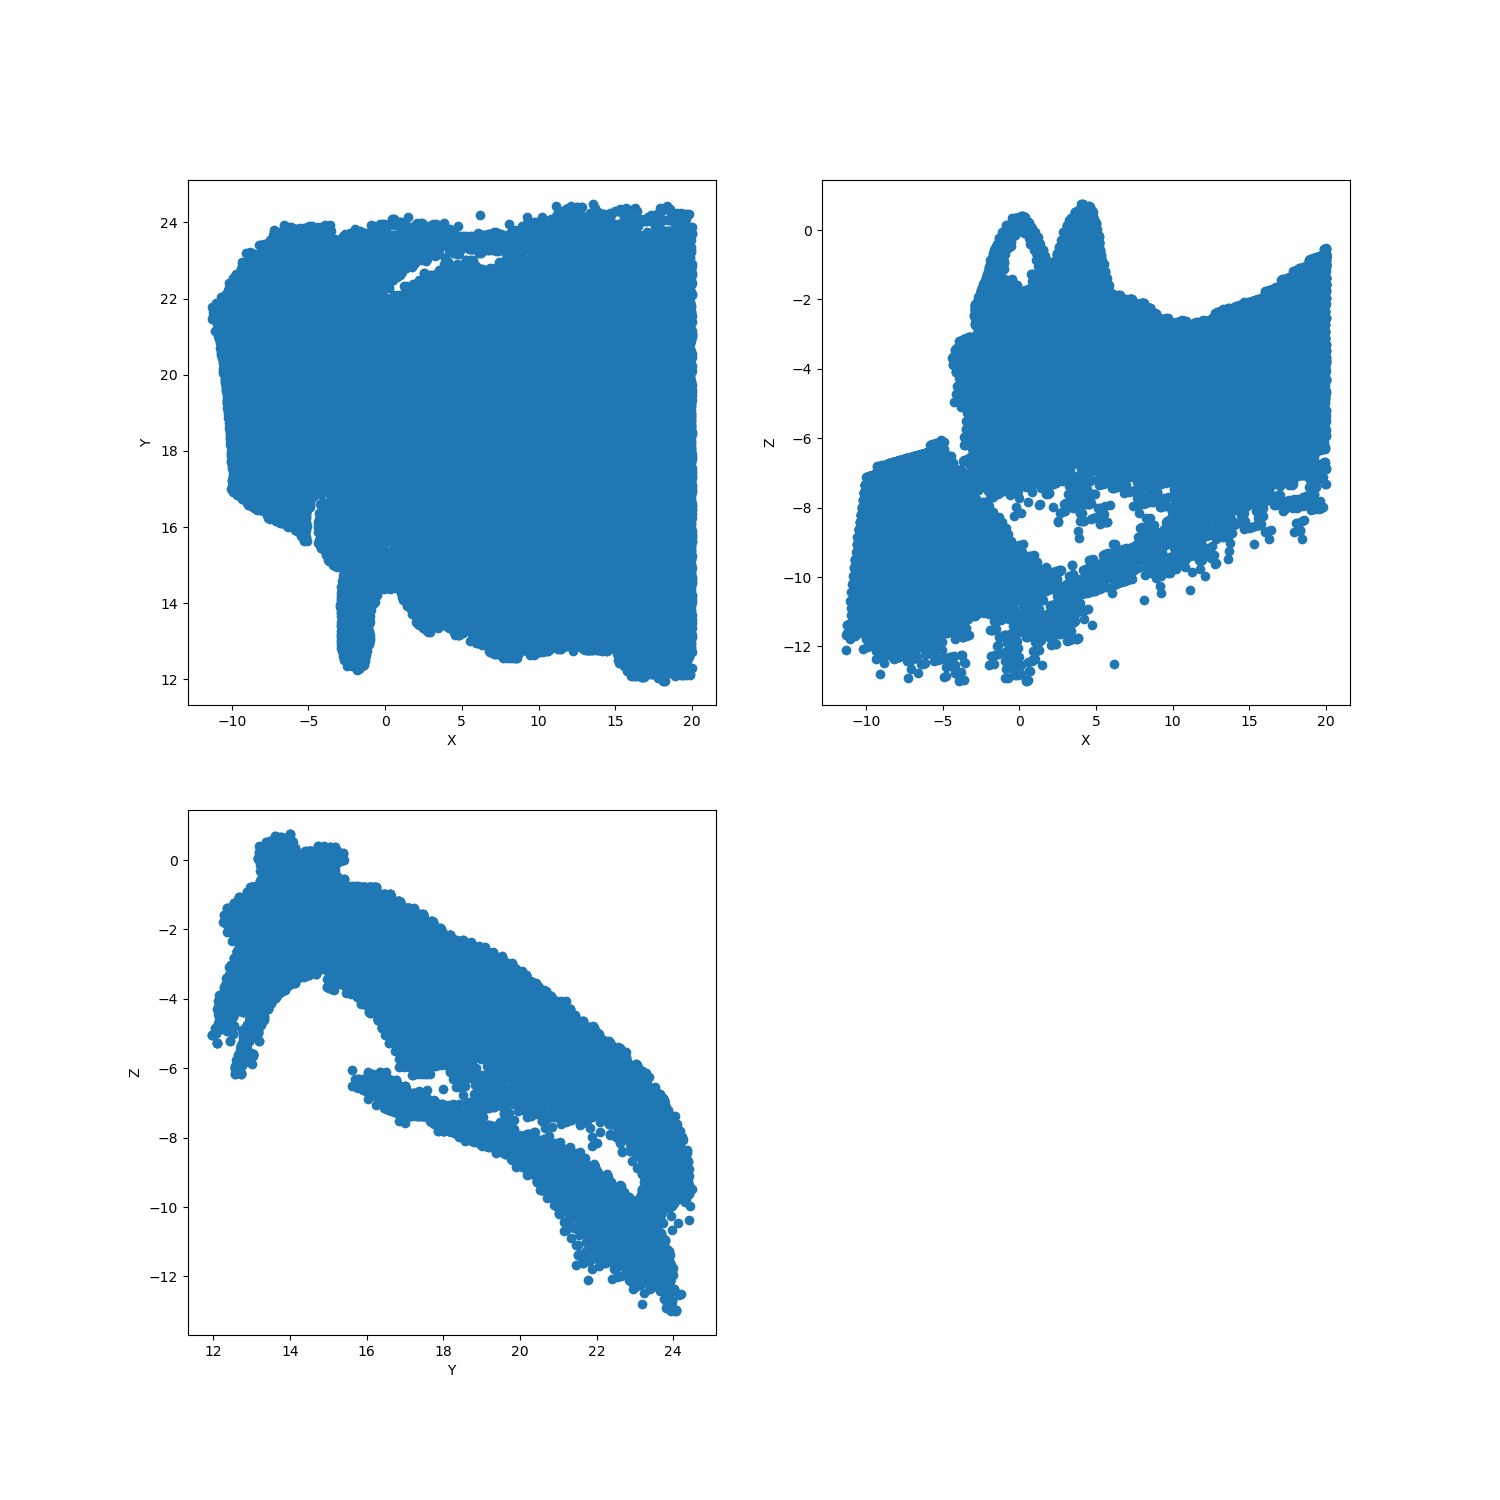

In [25]:

box_lims = [
    [-12,25,5,30,-17,5],
    [-20,20,-200,200,-20,0],
    [-12,20,10,25,-15,5],
    [-12,20,5,30,-15,0],
    
    [-10,20,15,30,-20,5],
    [-15,20,10,30,-22,2],
    [10,22,-200,200,-22,7]
]

blim = box_lims[model_view_index]

trithresh = 2


goodpts = np.nonzero((rot_pts3[0,:]>blim[0])&(rot_pts3[0,:]<blim[1]) & \
                  (rot_pts3[1,:]>blim[2])&(rot_pts3[1,:]<blim[3])& \
                  (rot_pts3[2,:]>blim[4])&(rot_pts3[2,:]<blim[5])) 


bnded_pts3 = rot_pts3[:,goodpts[0]]

if (final_version):
    plot_planes ( bnded_pts3)

pts2L = pts2L[:,goodpts[0]]
pts2R = pts2R[:,goodpts[0]]
colors = colors[:,goodpts[0]]

Triangles = Delaunay(pts2L.T)
tri = Triangles.simplices

def get_vertex_neighbors(vertex_ind, triangulation):

    start = triangulation.vertex_neighbor_vertices[0][vertex_ind]
    end = triangulation.vertex_neighbor_vertices[0][vertex_ind + 1]
    neighbors = triangulation.vertex_neighbor_vertices[1][start:end]

    return neighbors

def laplacian_smoothing(points, triang, lambda_factor, iterations):
    new_points = np.copy(points)

    for i in range(points.shape[1]):
        neighbors = get_vertex_neighbors(i, triang)
        if len(neighbors) > 0:
            neighbor_average = np.mean(points[:, neighbors], axis=1)
            new_points[:, i] += lambda_factor * (neighbor_average - points[:, i])

    points = new_points
    return points

lambda_factor = 1  
bnded_pts3 = laplacian_smoothing(bnded_pts3, Triangles, lambda_factor, 1)

d01 = np.sqrt(np.sum(np.power(bnded_pts3[:,tri[:,0]]-bnded_pts3[:,tri[:,1]],2),axis=0))
d02 = np.sqrt(np.sum(np.power(bnded_pts3[:,tri[:,0]]-bnded_pts3[:,tri[:,2]],2),axis=0))
d12 = np.sqrt(np.sum(np.power(bnded_pts3[:,tri[:,1]]-bnded_pts3[:,tri[:,2]],2),axis=0))

goodtri = (d01<trithresh)&(d02<trithresh)&(d12<trithresh)

tri = tri[goodtri,:]


tokeep = np.unique(tri)
remap = np.zeros(bnded_pts3.shape[1],dtype='int')
remap[tokeep]= np.arange(0,tokeep.shape[0])
bnded_pts3 = bnded_pts3[:,tokeep]
tri = remap[tri]



<IPython.core.display.Javascript object>


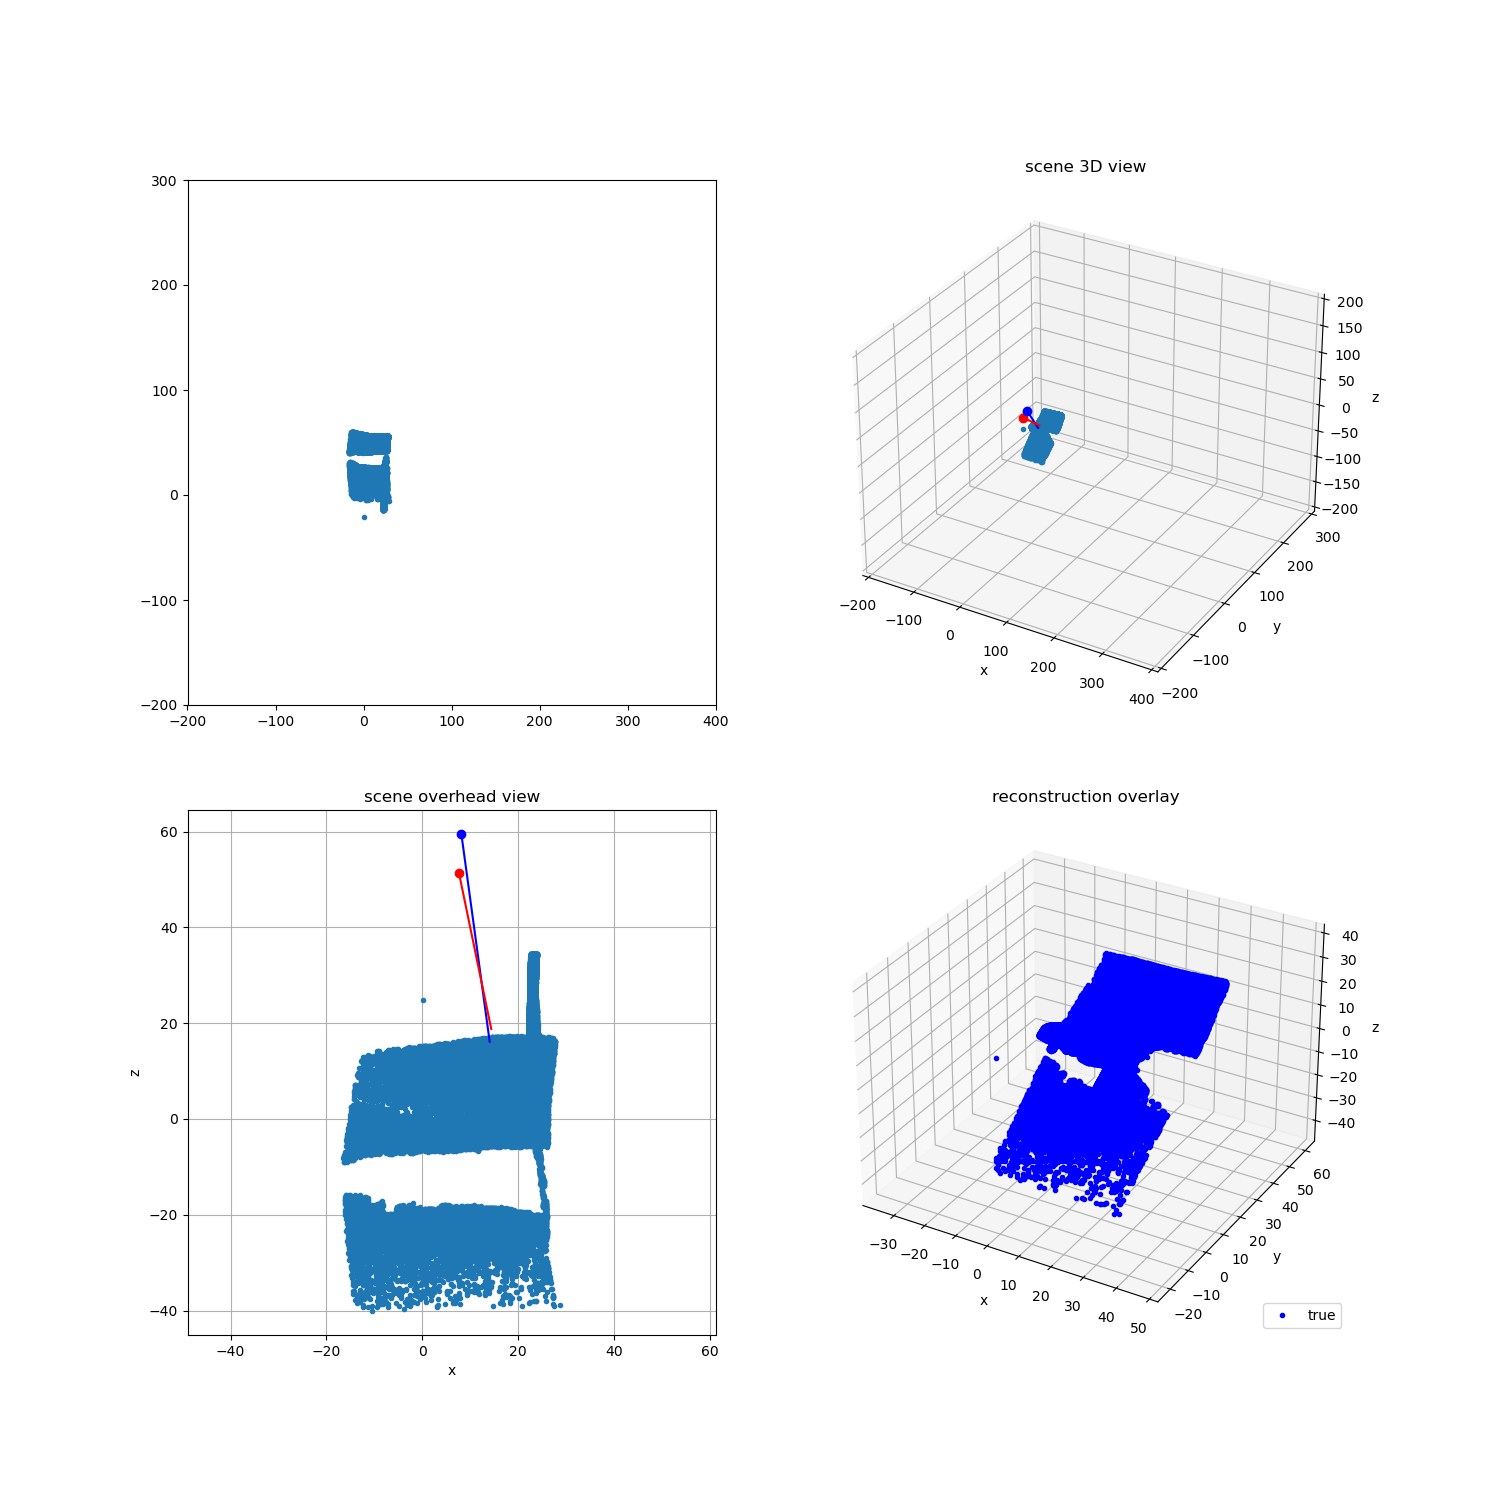

<IPython.core.display.Javascript object>


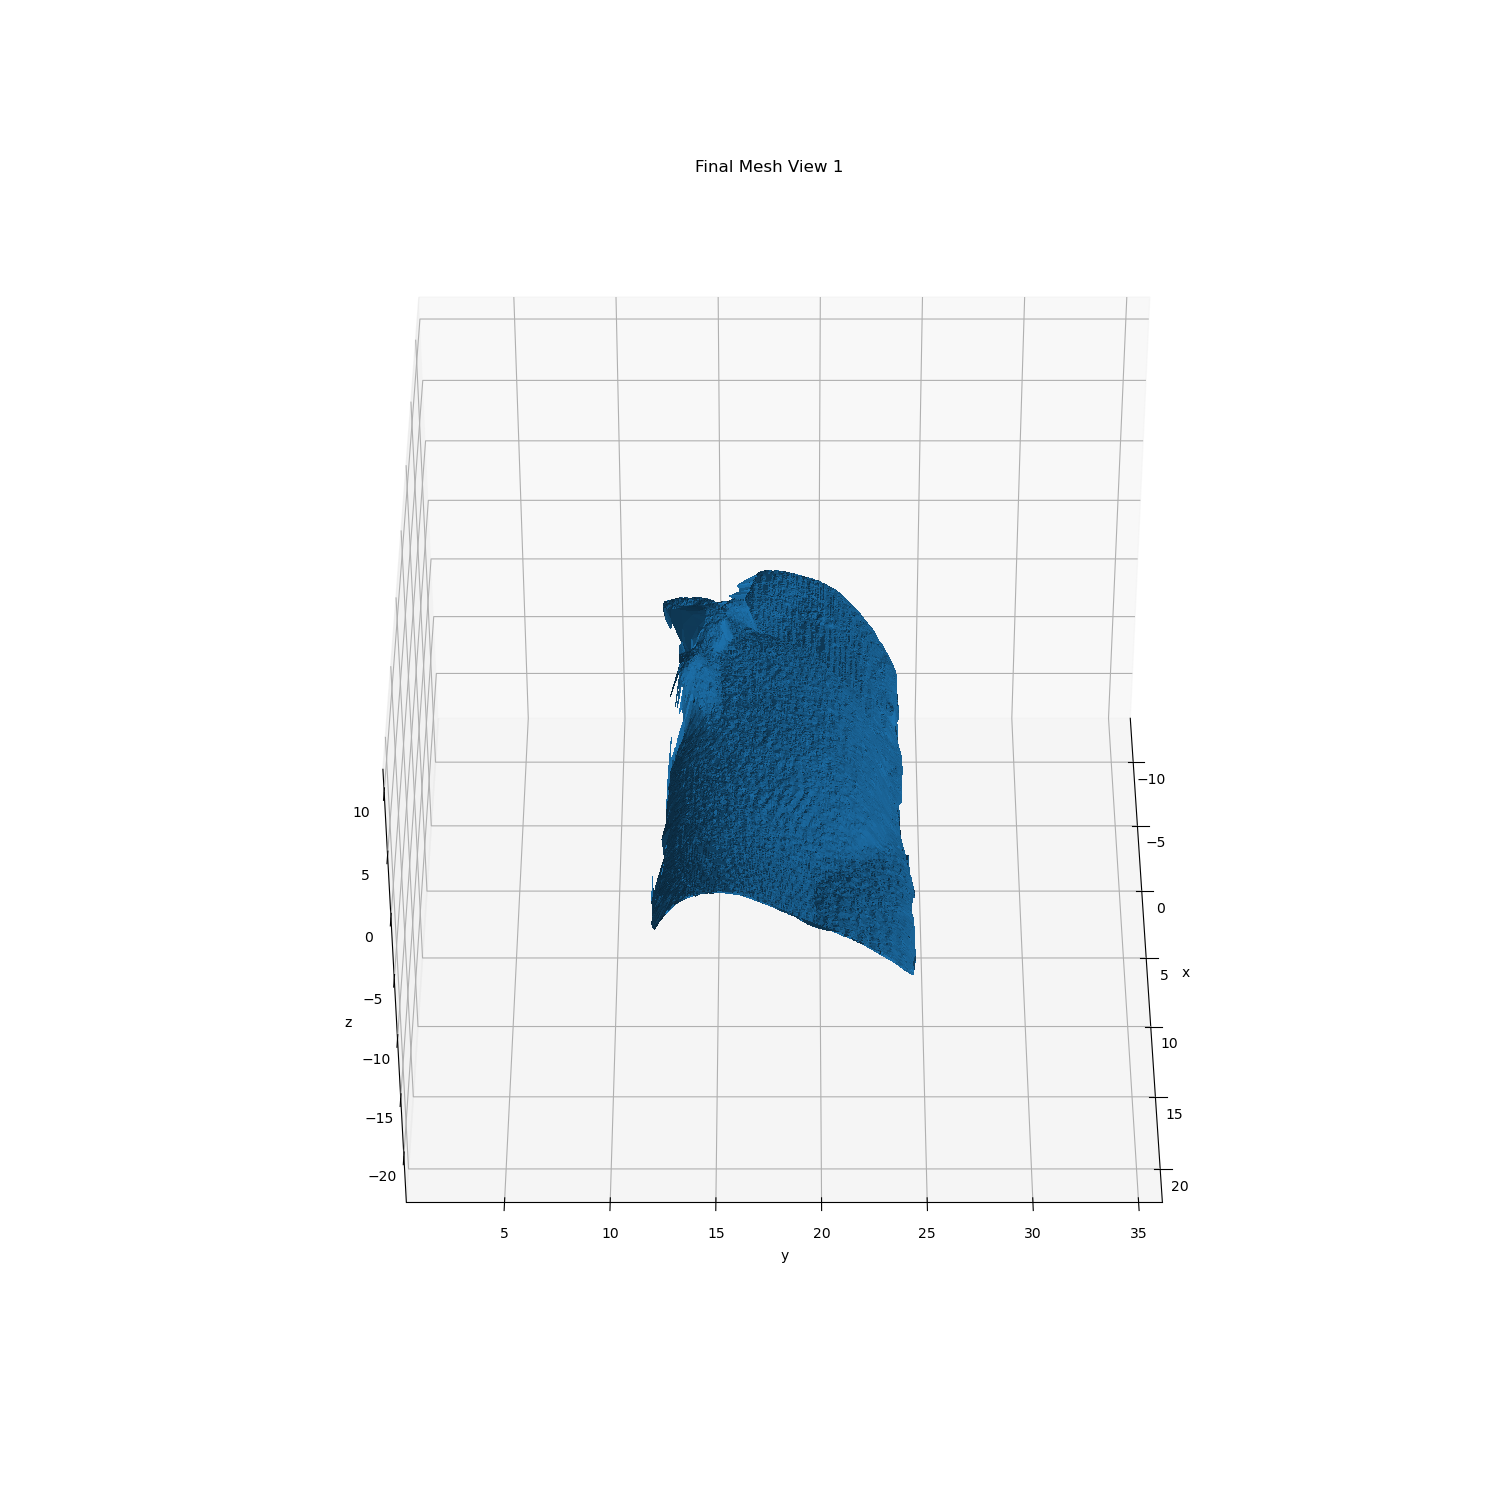

In [26]:
# vis code goes here
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,50]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,50]]).T))

tL = camL.t
tR = camR.t
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.plot(pts3[0,:],pts3[1,:],'.')
plt.axis([-200, 400, -200, 300])


#visualize 3D layout of points, camera positions
# and the direction the camera is pointing
ax = fig.add_subplot(2,2,2,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(tR[0],tR[1],tR[2],'ro')
ax.plot(tL[0],tL[1],tL[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
ax.set_xlim3d([-200, 400])
ax.set_ylim3d([-200, 300])
ax.set_zlim3d([-200, 200])
visutils.label_axes(ax)
plt.title('scene 3D view')

# overhead view showing points, camera
# positions, and direction camera is pointed
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(tL[0],tL[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(tR[0],tR[2],'ro')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')
plt.title('scene overhead view')

# compare reconstruction
ax = fig.add_subplot(2,2,4,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'b.')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('reconstruction overlay')
plt.legend(('true','reconstruction'),loc=4)

#
# example code using plot_trisurf to visualize... this will be 
# a bit slow so you have to be patiennt
#
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.plot_trisurf(bnded_pts3[0,:], bnded_pts3[1,:], bnded_pts3[2,:], triangles=tri,antialiased=False)
#ax.plot_trisurf(rot_pts3[2,:], rot_pts3[1,:], rot_pts3[0,:], triangles=tri,antialiased=False)
ax.view_init(azim=0,elev=40)  #set the camera viewpointn
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('Final Mesh View 1')
plt.show()

#
# An alternative is to use the trimesh library (https://github.com/mikedh/trimesh)
# you will need to install it via. "pip install trimesh"
# A nice feature is that it will create a plot which is interactive (so you can
# drag with the mouse pointer to rotate the 3D mesh to view from different directions)
#
mesh = trimesh.Trimesh(vertices=bnded_pts3.T,faces=tri[:,[0,2,1]])
mesh.show(smooth=True)

In [14]:

# save_path = "./pickled.pickle"
# to_pickle = dict()
# to_pickle['pts3'] = bnded_pts3
# to_pickle['tri'] = tri
# with open(save_path, 'wb') as handle:
#     pickle.dump(to_pickle, handle, protocol=pickle.HIGHEST_PROTOCOL)


def writeply(X,color, tri,filename):
    """
    Save out a triangulated mesh to a ply file
    
    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        vertex coordinates shape (3,Nvert)
        
    color : 2D numpy.array (dtype=float)
        vertex colors shape (3,Nvert)
        
    tri : 2D numpy.array (dtype=float)
        triangular faces shape (Ntri,3)
        
    filename : string
        filename to save to    
    """
    f = open(filename,"w");
    f.write('ply\n');
    f.write('format ascii 1.0\n');
    f.write('element vertex %i\n' % X.shape[1]);
    f.write('property float x\n');
    f.write('property float y\n');
    f.write('property float z\n');
#     f.write('property float nx\n');
#     f.write('property float ny\n');
#     f.write('property float nz\n');
    f.write('property uchar red\n');
    f.write('property uchar green\n');
    f.write('property uchar blue\n');
    f.write('element face %d\n' % tri.shape[0]);
    f.write('property list uchar int vertex_indices\n');
    f.write('end_header\n');

    C = (255*color).astype('uint8')

    

    for i in range(X.shape[1]):
        f.write('%f %f %f %i %i %i\n' % (X[0,i],X[1,i],X[2,i],C[0,i],C[1,i],C[2,i]));
            
    for t in range(tri.shape[0]):
        f.write('3 %d %d %d\n' % (tri[t,1],tri[t,0],tri[t,2]))

    f.close();

In [15]:
writeply( bnded_pts3, colors, tri, f"./mesh_{model_view_index}.ply")
